In [1]:
import pandas as pd
from utilsforecast.plotting import plot_series
from ray import tune
from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast
import matplotlib.pyplot as plt

/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data = pd.read_csv('../datasets/ETT-small/ETTh1.csv', parse_dates=['date'])
#create id column 
data['unique_id'] = 1
# transform date column into datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data.rename(columns={'date': 'ds', 'OT': 'y'}, inplace=True)
data

,ds,HUFL,HULL,MUFL,MULL,LUFL,LULL,y,unique_id
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,1
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,1
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,1
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,1
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,1
...,...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000,1
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000,1
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000,1
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000,1


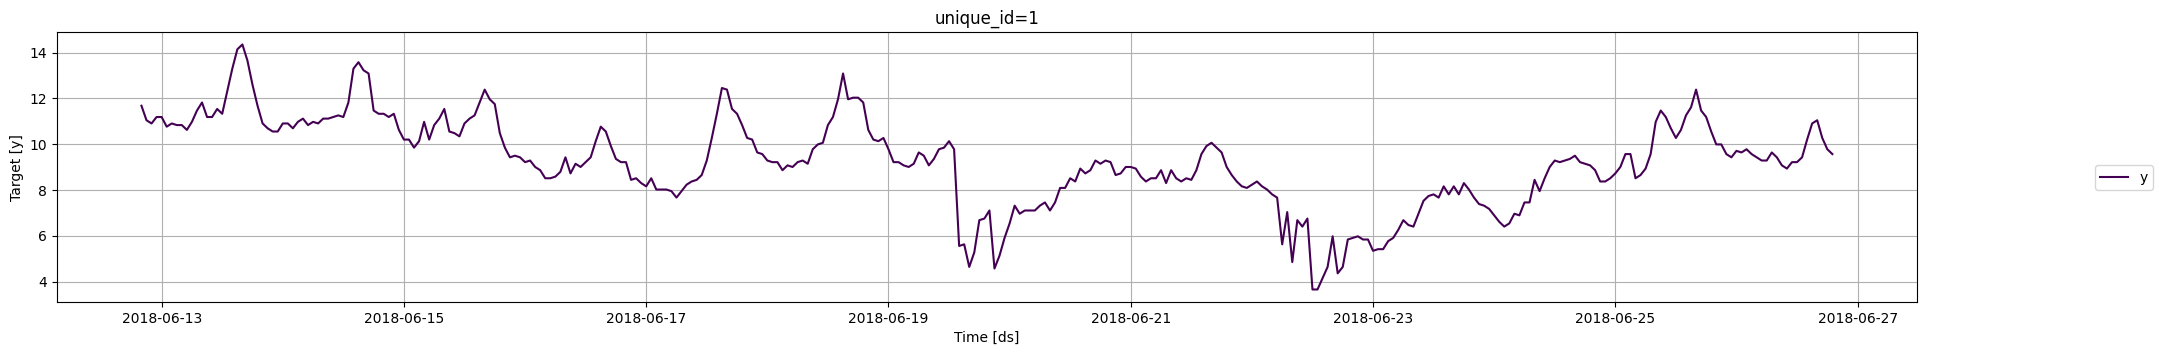

In [3]:
fig = plot_series(data, max_insample_length=24 * 14)
fig

In [4]:
train = data[:8640]
valid = data[8304:11520]
test = data[11184:14400]

In [5]:
horizon = 96 # 24hrs = 4 * 15 min.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([100]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }

In [6]:
models = [AutoNHITS(h=horizon,
                    config=nhits_config, 
                    num_samples=5)]

In [7]:
val_size = len(valid)
test_size = len(test)

In [10]:
nf = NeuralForecast(
    models=models,
    freq='1H')

In [11]:
Y_hat_df = nf.cross_validation(df=data, val_size=val_size,
                               test_size=test_size, n_windows=None)

(_train_tune pid=9245) Seed set to 8


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-10-31 18:11:31,300	ERROR tune_controller.py:1502 -- Trial task failed for trial _train_tune_5c800_00000
Traceback (most recent call last):
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/_private/worker.py", line 2547, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(NotImplementedError): ray::ImplicitFunc.train() (pid=9245, ip=127.0.0.1, actor_id=fe1da8cefc88661c9d30441101000000, repr=_train_tune)
  File "/Users/matteopanci

Sanity Checking: |          | 0/? [00:00<?, ?it/s] [repeated 2x across cluster]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-10-31 18:11:37,221	ERROR tune_controller.py:1502 -- Trial task failed for trial _train_tune_5c800_00002
Traceback (most recent call last):
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/_private/worker.py", line 2547, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(NotImplementedError): ray::ImplicitFunc.train() (pid=9266, ip=127.0.0.1, actor_id=44b6889a495c5142f68b66ce01000000, repr=_train_tune)
  File "/Users/matteopanci

Sanity Checking: |          | 0/? [00:00<?, ?it/s] [repeated 2x across cluster]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-10-31 18:11:43,242	ERROR tune_controller.py:1502 -- Trial task failed for trial _train_tune_5c800_00004
Traceback (most recent call last):
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/ray/_private/worker.py", line 2547, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(NotImplementedError): ray::ImplicitFunc.train() (pid=9291, ip=127.0.0.1, actor_id=78de4da870e4d875d4b9bff601000000, repr=_train_tune)
  File "/Users/matteopanci

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [ ]:
nf.models[0].results.get_best_result().config

In [ ]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoNHITS'].values

n_series = len(data.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
fig.tight_layout()

series = ['HUFL','HULL','LUFL','LULL','MUFL','MULL','OT']
series_idx = 3

for idx, w_idx in enumerate([200, 300, 400]):
  axs[idx].plot(y_true[series_idx, w_idx,:],label='True')
  axs[idx].plot(y_hat[series_idx, w_idx,:],label='Forecast')
  axs[idx].grid()
  axs[idx].set_ylabel(series[series_idx]+f' window {w_idx}', 
                      fontsize=17)
  if idx==2:
    axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
plt.legend()
plt.show()
plt.close()